In [1]:
import kwant 
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass, asdict
from kwant.continuum import discretize  
sx = np.array([[0 , 1] , [1 , 0]])
sy = np.array([[0 , -1j] , [1j , 0]])
sz = np.array([[1 , 0] , [0 , -1]])
id = np.array([[1 , 0] , [0 , 1]])

%matplotlib widget

/Users/krishnanganesh/anaconda3/lib/python3.8/site-packages/kwant/solvers/default.py:16: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  warnings.warn("MUMPS is not available, "


#### Contents of notebook
1. Construct a finite sized system and calculate spectrum + eigenvectors.
2. Plot spectrum and wavefunctions to check for presence of Majorana zero modes.
3. Compute the current phase relationship of the junction.
4. Calculate the critical current for several Zeeman couplings to look for signs of topological phase transition.

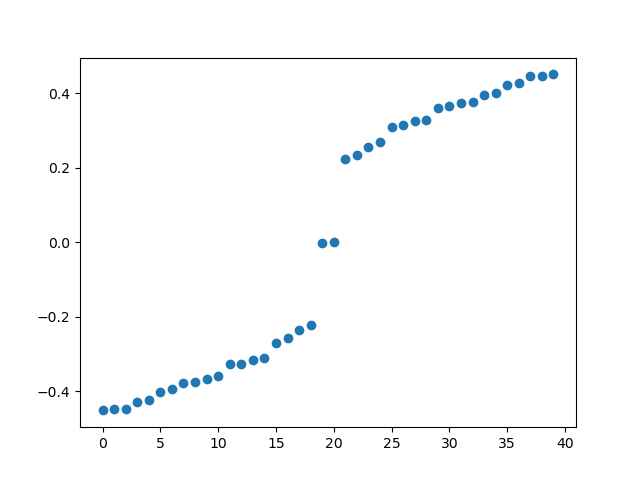

In [2]:
from scipy import constants
from sympy import exp
from josephson_current_tools import constants
@dataclass
class parameters:
    a : float # Lattice constant
    L_x : float # Dimension of planar system in x direction
    L_y : float # Dimension of planar system in y direction
    W : float # Width of the normal region in y direction
    m_eff : float # Effective mass
    mu : float # Chemical potential  
    alpha : float # Rashba coupling
    E_z : float # In plane Zeeman
    Delta : float # Superconducting gap
    phase : float # Phase bias of Josephson junction
    k : float # Boltzmann constant
    T : float # Temperature
    current_unit: float # Current unit
def make_system(params , plot = False):
    
    # Continuum model:
    hamiltonian_bottom = """ (1/(2*m_eff))*(k_x**2 + k_y**2)*kron(sigma_z , sigma_0) - mu*kron(sigma_z , sigma_0) + 0.5*(m_eff*(alpha**2))*kron(sigma_z, sigma_0) 
    + alpha*k_x*kron(sigma_z , sigma_y) - alpha*k_y*kron(sigma_z , sigma_x) + E_z*kron(sigma_0 , sigma_x) + Delta*kron(sigma_x , sigma_0)"""

    hamiltonian_top = """ (1/(2*m_eff))*(k_x**2 + k_y**2)*kron(sigma_z , sigma_0) - mu*kron(sigma_z , sigma_0) + 0.5*(m_eff*(alpha**2))*kron(sigma_z, sigma_0) 
    + alpha*k_x*kron(sigma_z , sigma_y) - alpha*k_y*kron(sigma_z , sigma_x) + E_z*kron(sigma_0 , sigma_x) + 0.5*Delta*exp1*kron(sigma_x + I*sigma_y , sigma_0) 
    + 0.5*Delta*exp2*kron(sigma_x - I*sigma_y , sigma_0) 
    """

    template_sc_top = discretize(hamiltonian_top , locals = {'exp1' : np.exp(1j*params.phase) , 'exp2': np.exp(-1j*params.phase) } ,  grid = params.a )
    template_sc_bottom = discretize(hamiltonian_bottom , grid = params.a)
    template_normal = discretize(hamiltonian_bottom , locals =  {'Delta' : 0 , 'E_z' : 0 } , grid = params.a)

    half_w = params.W // 2
    half_L_y = params.L_y // 2

    def normal_region_color(site):
        if normal_region(site) == True:
            return 'red'
        else: 
            return 'blue'

    def normal_region(site):
        (x , y) = site.pos
        return ((half_L_y - half_w)< y < (half_L_y + half_w))   and (0<= x < params.L_x)
    
    def bottom_super_region(site):
        (x , y) = site.pos
        return (0 <=y <= (half_L_y - half_w)) and (0<=x < params.L_x)
    
    def top_super_region(site):
        (x , y) = site.pos
        return ((half_L_y + half_w)  <= y < params.L_y) and (0 <= x < params.L_x)


    syst = kwant.Builder()
    syst.fill(template_sc_bottom , bottom_super_region , (0 , 0) )
    syst.fill(template_normal , normal_region , (0 , (half_L_y - half_w) + 1))
    syst.fill(template_sc_top , top_super_region , (0 , (half_L_y + half_w)))

    if plot == True:
        kwant.plot(syst , site_lw = 0.1 ,  site_color = normal_region_color );
    
    return syst.finalized()



params = parameters(a = 0.25 , L_x = 50, L_y = 21 , W  = 2 , m_eff = 0.5 , mu = 5 , alpha = 1.0 , E_z= 1.5 , Delta = 2.0 , phase = np.pi*1.0 , k = constants.k , T = 0.05 , current_unit = constants.current_unit)
syst  = make_system(params , plot = False)


import scipy.sparse.linalg as sla
ham = syst.hamiltonian_submatrix(params = asdict(params) , sparse = True)
# These are various solving and plotting functions:
def solve_me(ham, number):
    eigenvalues , eigenvectors = sla.eigsh(ham , k = number , sigma = 0.0 , which = 'LM')

    idx = np.argsort(np.abs(eigenvalues))
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[: , idx]

    return eigenvalues , eigenvectors

evals , evecs = solve_me(ham , 40)

plt.figure()
plt.scatter(np.arange(len(evals)),evals[np.argsort(evals)])



[-0.00060616  0.00060616  0.22289533 -0.22289533  0.23513693 -0.23513693
 -0.2565805   0.2565805  -0.26998262  0.26998262  0.3104647  -0.3104647
  0.3145711  -0.3145711  -0.3253662   0.3253662  -0.32728053  0.32728053
 -0.35983385  0.35983385  0.36562835 -0.36562835 -0.37367895  0.37367895
 -0.37615803  0.37615803 -0.39472061  0.39472061 -0.4013663   0.4013663
  0.42389248 -0.42389248 -0.42922228  0.42922228  0.4465711  -0.4465711
 -0.44794424  0.44794424 -0.45101418  0.45101418]


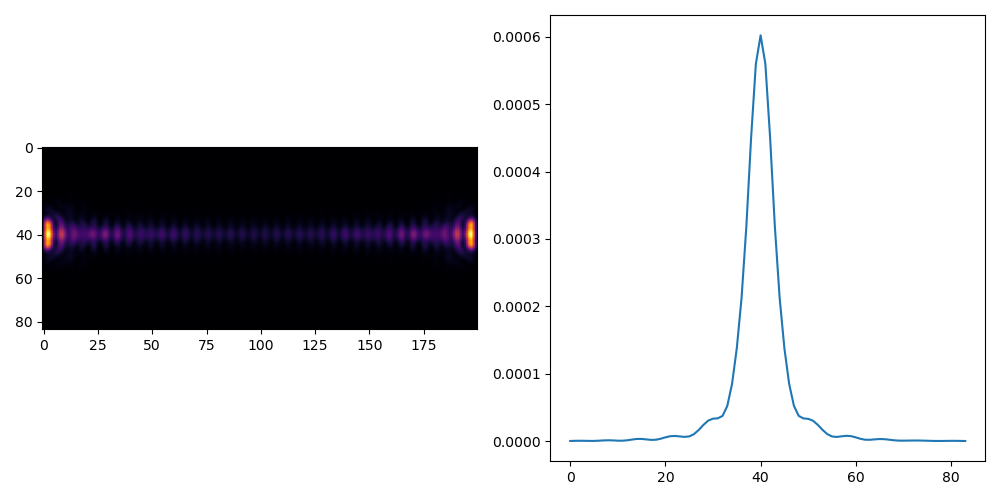

In [3]:
print(evals)
def see_the_funk(k , ev , params):
    psi = ev[: , k]
    innerprod = np.conjugate(psi) * psi
    prob_density = np.array([sum(innerprod[i : i + 4]) for i in range(0 , len(innerprod), 4)])
    wavefunc = np.reshape(prob_density , ((int(params.L_x/params.a)) , int(params.L_y/params.a)))
    return np.real(wavefunc.T)

wf = see_the_funk(5 , evecs , params)
fig , ax = plt.subplots(nrows = 1 , ncols = 2)
fig.set_figwidth(10)
fig.set_figheight(5)
ax[0].imshow(wf , cmap = 'inferno')
ax[1].plot(wf[ : , wf.shape[0]//4])
plt.tight_layout()



In [4]:
# Let's also see if we can reproduce the critical dips as a function of zeeman field:
import josephson_current_tools as jct
def make_josephson_junction(params):
        
    # Continuum model:
    hamiltonian = """ (1/(2*m_eff))*(k_x**2 + k_y**2)*kron(sigma_z , sigma_0) - mu*kron(sigma_z , sigma_0) + 0.5*(m_eff*(alpha**2))*kron(sigma_z, sigma_0) 
    + alpha*k_x*kron(sigma_z , sigma_y) - alpha*k_y*kron(sigma_z , sigma_x) + E_z*kron(sigma_0 , sigma_x) + Delta*kron(sigma_x , sigma_0)"""

    template_normal = discretize(hamiltonian , locals =  {'Delta' : 0 , 'E_z' : 0 } , grid = params.a)
    template_sc = discretize(hamiltonian , grid = params.a)
    syst = kwant.Builder()
    syst.fill(template_normal , lambda s: 0<=s.pos[0] < params.L_x and 0 <= s.pos[1]<= params.W , (0 , 0))

    lat = template_normal.lattice

    # Getting cuts and adding virtual leads to the cuts:
    cuts= jct.get_cuts(syst , lat)
    syst = jct.add_vlead(syst , lat , *cuts , asdict(params))

    # Adding superconducting leads:
    lead = kwant.Builder(kwant.TranslationalSymmetry((0 , -params.a)))
    lead.fill(template_sc , lambda s: 0 <= s.pos[0] < params.L_x , (0 , 0))
    syst.attach_lead(lead)

    syst.attach_lead(lead.reversed())
                     
    syst = syst.finalized()

    hopping = jct.hopping_between_cuts(syst, *cuts)

    return syst , hopping

jsyst , hopping = make_josephson_junction(params)

phases = np.linspace(0 , 2*np.pi , 51)
CPR = jct.calculate_CPR(jsyst, hopping , asdict(params) , phases , tol = 1e-3 )

plt.figure()
plt.plot(phases , CPR)

    

KeyboardInterrupt: 

In [ ]:
# CPRS and critical currents as we sweep through Zeeman couplings
E_z_values = np.linspace(0 , 10 , 81)
phases = np.linspace(0 , 2*np.pi , 21)
data = []

from tqdm import tqdm
for i in tqdm(range(len(E_z_values))):
    params = parameters(a = 1.0 , L_x = 20, L_y = 21 , W  = 2 , m_eff = 0.5 , mu = 2.4 , alpha =1.0 , E_z= E_z_values[i] , Delta = 1.0 , phase = np.pi*1.0 , k = constants.k , T = 0.08 , current_unit = constants.current_unit)
    syst , hopping = make_josephson_junction(params)
    data.append(jct.I_c(syst , hopping , asdict(params)))

  0%|          | 0/81 [00:00<?, ?it/s]

 70%|███████   | 57/81 [02:35<01:21,  3.38s/it]/Users/krishnanganesh/Desktop/Josephson Investigations/Josephson effect and Supercurrents/Rashba2DEGJunction/josephson_current_tools.py:224: RuntimeWarning: divide by zero encountered in double_scalars
  if I_contrib == 0 or tol is not None and abs(I_contrib / I) < tol:
100%|██████████| 81/81 [03:41<00:00,  2.73s/it]


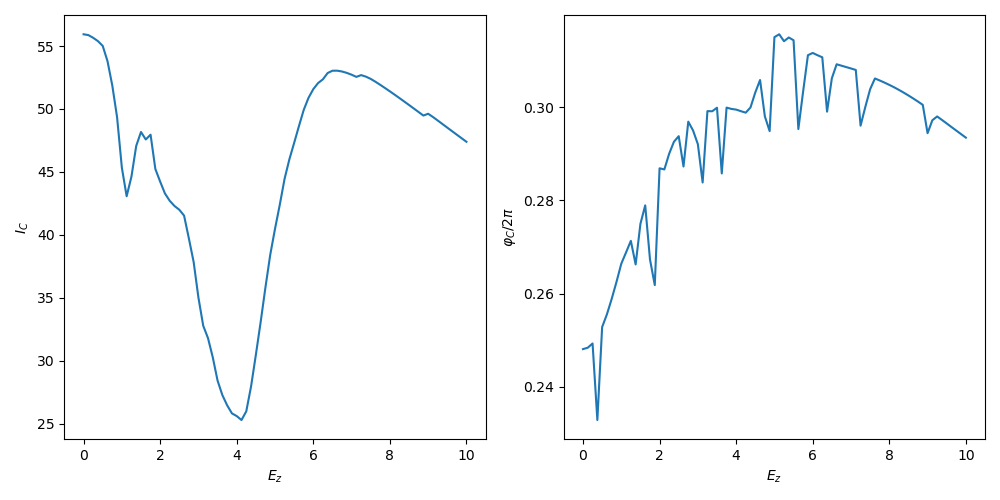

In [95]:
# Extracting critical currents and phases from the data array:
phase_c = np.zeros_like(E_z_values)
current_c = np.zeros_like(E_z_values)
for i in range(len(data)):
    phase_c[i] = data[i]['phase_c']
    current_c[i] = data[i]['current_c']

fig , ax = plt.subplots(nrows= 1 , ncols = 2 )
fig.set_figwidth(10)
fig.set_figheight(5)    
ax[0].plot(E_z_values , current_c)
ax[0].set_xlabel(r'$E_z$')
ax[0].set_ylabel(r'$I_{C}$')
ax[1].plot(E_z_values , phase_c / (2*np.pi))
ax[1].set_xlabel(r'$E_z$')
ax[1].set_ylabel(r'$\varphi_{C} / 2\pi$')
plt.tight_layout()